In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from d2l import torch as d2l
from torchvision import transforms
import torchvision

In [49]:
class Reshape(nn.Module):
    def forward(self, x):
        return x.reshape((-1, 1, 28, 28))

In [50]:
net = nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6 ,kernel_size=5, padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(400, 120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

In [51]:
x = torch.zeros((1,1,28,28))
for layer in net:
    x = layer(x)
    print(f"{type(layer).__name__} output shape:\t {x.shape}")

Reshape output shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [52]:
def load_data_mnist(batch_size, resize=None):
    """Download MNIST dataset and then load it into memory.

    Defined in :numref:`sec_utils`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                        num_workers=8),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                        num_workers=8))

In [53]:
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size=batch_size)

In [54]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [55]:
lr, epoches = 0.9, 10

loss 0.135, train acc 0.957, test acc 0.962
108256.0 examples/sec on cuda:0


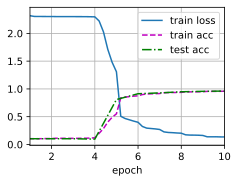

In [56]:
train(net, train_iter, test_iter, epoches, lr, d2l.try_gpu())

In [57]:
#visualize the first layer of the network
d2l.set_figsize()
def show_filters(filters, n_cols, n_rows):
    d2l.use_svg_display()
    _, axes = d2l.plt.subplots(n_rows, n_cols)
    for i in range(n_rows):
        for j in range(n_cols):
            axes[i][j].imshow(filters[i * n_cols + j].detach(), cmap='gray')
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

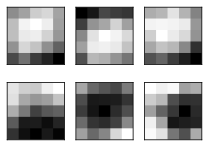

In [58]:
show_filters(net.to("cpu")[1].weight.data.reshape(6, 5, 5), n_cols=3, n_rows=2)

In [59]:
# visualize the result of evaluation
def get_mnist_labels(labels):
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

In [60]:
def predict_and_show(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_mnist_labels(y)
    preds = get_mnist_labels(net(X).argmax(axis=1))
    titles = [true + "->" + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 2, 5, titles=titles[0:n], scale=2)

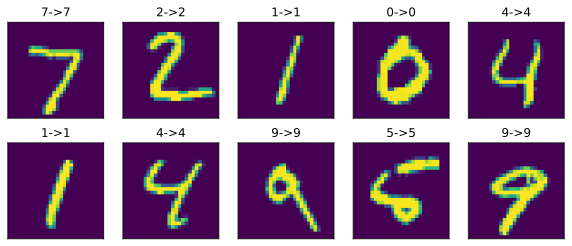

In [61]:
predict_and_show(net, test_iter, n=10)

In [62]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [63]:
def extract_first_layer(net):
    return nn.Sequential(*[net[i] for i in range(0,5)])

In [64]:
layer = extract_first_layer(net)
X = layer(next(iter(test_iter))[0])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

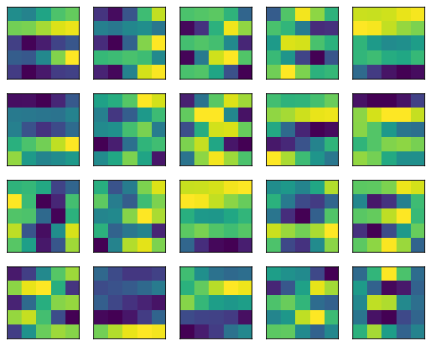

In [65]:
show_images(X.detach().reshape((-1,5,5))[0:20], 4, 5)

In [66]:
# save the model with constructed network
torch.save(net.state_dict(), "models/LeNet_MNIST.pth")